In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        #for p in self.parameters():
        #    print ("P=", p.shape) 
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.966750 32: 0.960329 64: 0.964255
Train Epoch: 1 [12800/50000 (26%)]	Losses 16: 0.493734 32: 0.417761 64: 0.348860
Train Epoch: 1 [25600/50000 (51%)]	Losses 16: 0.324482 32: 0.304055 64: 0.289953
Train Epoch: 1 [38400/50000 (77%)]	Losses 16: 0.305241 32: 0.297536 64: 0.291189
Train Epoch: 1 [12512/50000 (100%)]	Losses 16: 0.281261 32: 0.275778 64: 0.270669
Test set:
16: loss: 0.2834	pho_loss: 0.0032
32: loss: 0.2787	pho_loss: 0.0033
64: loss: 0.2744	pho_loss: 0.0033

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.275950 32: 0.270984 64: 0.266564
Train Epoch: 2 [12800/50000 (26%)]	Losses 16: 0.280235 32: 0.276882 64: 0.274404
Train Epoch: 2 [25600/50000 (51%)]	Losses 16: 0.282665 32: 0.279215 64: 0.276548
Train Epoch: 2 [38400/50000 (77%)]	Losses 16: 0.260852 32: 0.258998 64: 0.258218
Train Epoch: 2 [12512/50000 (100%)]	Losses 16: 0.254688 32: 0.251987 64: 0.252174
Test set:
16: loss: 0.2622	pho_loss: 0.0031
32: loss: 0.2608	pho_loss: 0.0031
64: los

Train Epoch: 17 [12800/50000 (26%)]	Losses 16: 0.135115 32: 0.114233 64: 0.109902
Train Epoch: 17 [25600/50000 (51%)]	Losses 16: 0.143121 32: 0.121028 64: 0.118094
Train Epoch: 17 [38400/50000 (77%)]	Losses 16: 0.148758 32: 0.120928 64: 0.114346
Train Epoch: 17 [12512/50000 (100%)]	Losses 16: 0.143180 32: 0.111246 64: 0.108912
Test set:
16: loss: 0.1400	pho_loss: 0.0032
32: loss: 0.1170	pho_loss: 0.0032
64: loss: 0.1107	pho_loss: 0.0032

Train Epoch: 18 [0/50000 (0%)]	Losses 16: 0.124613 32: 0.102489 64: 0.096990
Train Epoch: 18 [12800/50000 (26%)]	Losses 16: 0.149300 32: 0.121312 64: 0.114774
Train Epoch: 18 [25600/50000 (51%)]	Losses 16: 0.146217 32: 0.121428 64: 0.117364
Train Epoch: 18 [38400/50000 (77%)]	Losses 16: 0.135404 32: 0.113271 64: 0.107781
Train Epoch: 18 [12512/50000 (100%)]	Losses 16: 0.131514 32: 0.107611 64: 0.101554
Test set:
16: loss: 0.1356	pho_loss: 0.0032
32: loss: 0.1129	pho_loss: 0.0032
64: loss: 0.1059	pho_loss: 0.0031

Train Epoch: 19 [0/50000 (0%)]	Losses 1

In [9]:
torch.save(models['64'], './model_64_kl_gn')


/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [6]:
model = torch.load('./model_64_kl_gn')

In [7]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 10,   5,   6,   5,   6,   5,   3,   3,   2,   4,   8,   0,
          8,   3,   5,   5,   6,   5,   4,   6,   6,   7,   2,   2,
          3,   5,   5,   6,   3,   6,   6,   7,   8,   2,   6,   2,
          3,   6,   1,   4,   4,   1,   4,   3,   6,   6,  12,   1,
          6,   6,   9,   3,   3,   3,   4,   3,   4,   5,   6,   4,
         11,   2,   1,   2])


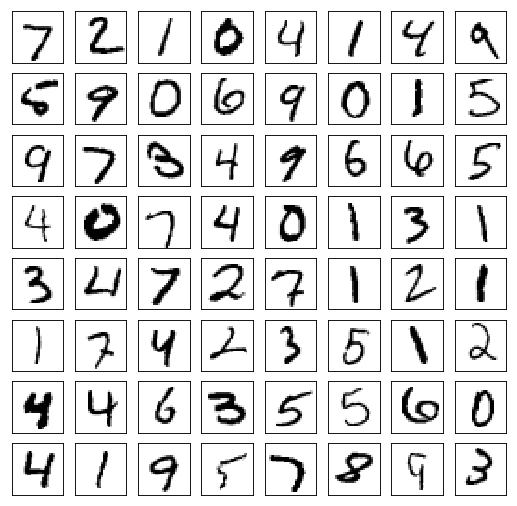

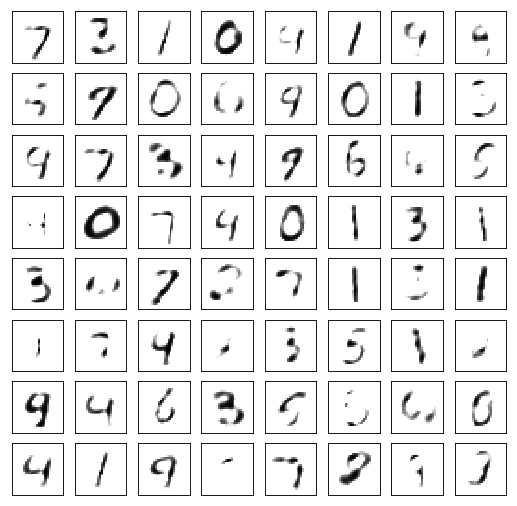

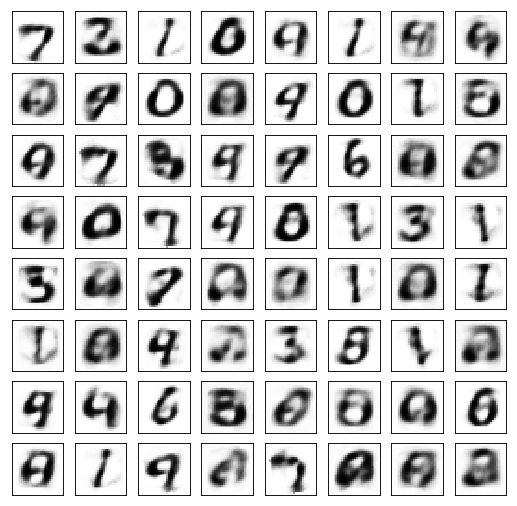

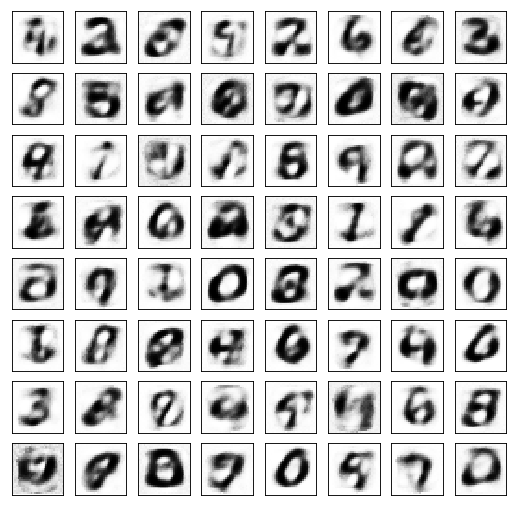

In [8]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

### Генерация новых изображений


In [9]:
from torch.autograd import Variable

In [10]:
w = Variable(torch.randn(784, 784), requires_grad=True)
b = Variable(torch.randn(784), requires_grad=True)

w_optimizer = optim.Adam([w,b], lr=1)

def train_generator(epoch):
    loss_stats = []
    
    for batch_idx, (data, target) in enumerate(train_loader):

        w_optimizer.zero_grad()
        x = data.view(-1, 28*28)
       
        y = torch.matmul(x, w) + b         
        
        target = model.E(y)
        latent_vector = torch.eye(64) 

        # Используем только "полные" батчи
        if data.shape[0] == latent_vector.shape[0]:              
                    
            loss = F.mse_loss(target, latent_vector)
            loss.backward()
            w_optimizer.step()
            
            ls = loss.detach().numpy()            
            loss_stats.append(ls)               
    
    epoch_loss = np.mean(np.array(loss_stats), axis=0)      
    return epoch_loss

In [13]:

    epoch_loss = train_generator(epoch)
    
    print ("Epoch {} loss: {}".format(epoch, epoch_loss))
    if (epoch_loss < 0.01):
        print ("Loss is good .. stop")
        break

Epoch 1 loss: 0.018748758360743523
Epoch 2 loss: 0.016726640984416008
Epoch 3 loss: 0.016155103221535683
Epoch 4 loss: 0.01604735478758812
Epoch 5 loss: 0.016047365963459015
Epoch 6 loss: 0.01604732684791088
Epoch 7 loss: 0.016047334298491478
Epoch 8 loss: 0.016047345474362373
Epoch 9 loss: 0.016047349199652672
Epoch 10 loss: 0.01604730449616909
Epoch 11 loss: 0.016047362238168716
Epoch 12 loss: 0.01604735665023327
Epoch 13 loss: 0.016047324985265732
Epoch 14 loss: 0.016047310084104538
Epoch 15 loss: 0.016047345474362373
Epoch 16 loss: 0.016047319397330284
Epoch 17 loss: 0.016047345474362373
Epoch 18 loss: 0.016047315672039986
Epoch 19 loss: 0.016047338023781776
Epoch 20 loss: 0.016047317534685135
Epoch 21 loss: 0.016047345474362373
Epoch 22 loss: 0.016047341749072075
Epoch 23 loss: 0.016047362238168716
Epoch 24 loss: 0.01604735478758812
Epoch 25 loss: 0.016047345474362373
Epoch 26 loss: 0.016047338023781776
Epoch 27 loss: 0.016047319397330284
Epoch 28 loss: 0.016047349199652672
Epoch 

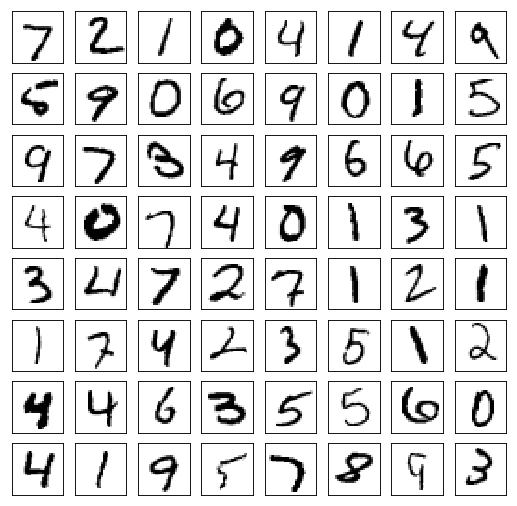

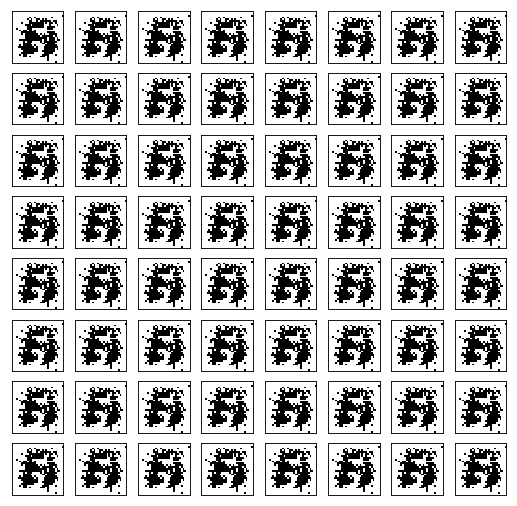

In [15]:
data, _ = next(iter(test_loader))
x = data.view(-1, 28*28)
output = torch.matmul(x, w) + b

to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
